In [2]:
import numpy as np
import pandas as pd
import easydatascience as eds

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_palette(sns.dark_palette("purple"))

data = pd.read_csv('train.csv', low_memory=False)

eds.look(data)

,Types,Counts,Distincts,Nulls,Missing ratio (%),Uniques,Skewness
GameId,int64,509762,512,0,0.0000,"[[2017090700, 2017091000, 2017091001, 20170910...",0.054325
PlayId,int64,509762,23171,0,0.0000,"[[20170907000118, 20170907000139, 201709070001...",0.054325
Team,object,509762,2,0,0.0000,"[[away, home]]",NaN
X,float64,509762,10890,0,0.0000,"[[73.91, 74.67, 74.0, 71.46, 69.32, 75.06, 74....",-0.018676
Y,float64,509762,4339,0,0.0000,"[[34.84, 32.64, 33.2, 27.7, 35.42, 24.0, 16.64...",-0.010044
S,float64,509762,884,0,0.0000,"[[1.69, 0.42, 1.22, 1.82, 1.01, 1.11, 1.24, 0....",0.474834
A,float64,509762,903,0,0.0000,"[[1.13, 1.35, 0.59, 0.54, 2.43, 0.32, 0.83, 0....",0.942757
Dis,float64,509762,105,0,0.0000,"[[0.4, 0.01, 0.31, 0.02, 0.16, 0.18, 0.13, 0.2...",0.257422
Orientation,float64,509744,36002,18,0.0035,"[[81.99, 27.61, 3.01, 359.77, 12.63, 308.34, 3...",0.000846
Dir,float64,509748,36002,14,0.0027,"[[177.18, 198.7, 202.73, 105.64, 164.31, 95.01...",-0.000100


# Imputation
-Firstly, let's impute the missing values and take a better look at the features with missing values. We will also try to transform them now rather than leaving them for later (if possible)

In [3]:
#Imputing features which have a few instances which are most likely missing at random
from sklearn.impute import SimpleImputer

imputer = SimpleImputer()
simple_impute_list = ['Orientation', 'Dir', 'DefendersInTheBox', 'Humidity']

for c in simple_impute_list:
    if c=='Humidity':
        data[c] = np.where(data[c]==0,data[c].mean(), data[c])
    data[c] = imputer.fit_transform(data[c].values.reshape(-1, 1))
    
data['FieldPosition'] = data['FieldPosition'].fillna(value='MidCourt')
data['OffenseFormation'] = data['OffenseFormation'].fillna(value=data['OffenseFormation'].mode()[0])

#eds.print_abv_corr(data, data['Humidity'])

rest_missing = [col for col in data.columns if data[col].isnull().any()]
print('---------------------\nRest missing columns:\n---------------------')
for i in rest_missing:
    print(i)

---------------------
Rest missing columns:
---------------------
StadiumType
GameWeather
Temperature
WindSpeed
WindDirection


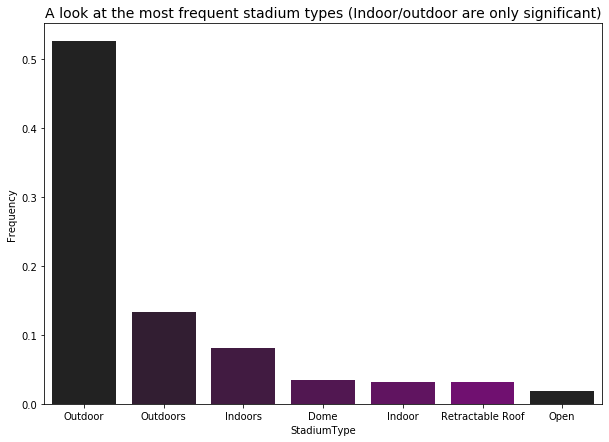

---------------------
New Stadium Type values:

StadiumType
Outdoors    0.798455
Indoors     0.201545
Name: StadiumType, dtype: float64
---------------------


In [4]:
stadium_type = pd.Series(data.groupby('StadiumType')['StadiumType'].count()/len(data))
stadium_type.name = 'Frequency'
most_freq_stads = stadium_type.sort_values(ascending=False)[:7]

ax, fig = plt.subplots(figsize=(10,7))
sns.barplot(x=most_freq_stads.index, y=most_freq_stads, palette=sns.color_palette())
plt.title('A look at the most frequent stadium types (Indoor/outdoor are only significant)',
          fontsize=14)

closed_dome = ['Bowl', 'Closed Dome', 'Dome', 'Dome, closed', 'Domed', 'Domed, closed',
               'Indoor', 'Indoor, Roof Closed', 'Indoors', 'Retr. Roof - Closed', 
               'Retr. Roof Closed', 'Retr. Roof-Closed']
data['StadiumType'] = np.where(data['StadiumType'].isin(closed_dome), 'Indoors', 'Outdoors')

plt.show()

print('---------------------\nNew Stadium Type values:\n')
eds.group_by(data, 'StadiumType')
print('---------------------')

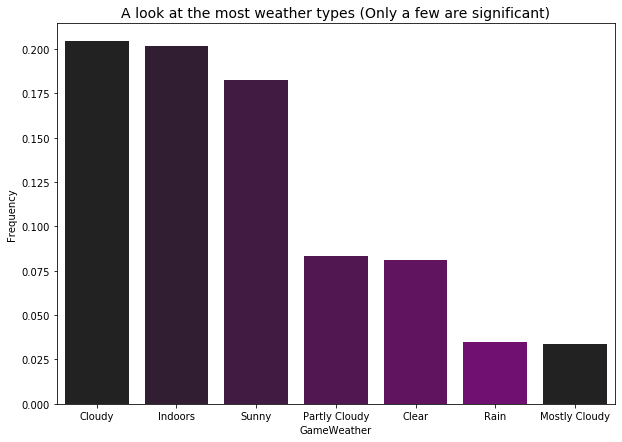

---------------------
Fequency within the Cloudy column:

Cloudy
0    0.567088
1    0.432912
Name: Cloudy, dtype: float64
---------------------


In [5]:
data['GameWeather'] = np.where(data['StadiumType']=='Indoors','Indoors', data['GameWeather'])

game_weather = pd.Series(data.groupby('GameWeather')['GameWeather'].count()/len(data))
game_weather.name = 'Frequency'
most_freq_weather = game_weather.sort_values(ascending=False)[:7]

ax, fig = plt.subplots(figsize=(10,7))
sns.barplot(x=most_freq_weather.index, y=most_freq_weather, palette=sns.color_palette())
plt.title('A look at the most weather types (Only a few are significant)', fontsize=14)

plt.show()

cloudy = ['30% Chance of Rain', 'Cloudy', 'Cloudy and Cool', 'Cloudy and cold', 'Cloudy, Rain',
          'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
          'Cloudy, 50% change of rain', 'Cloudy, chance of rain', 'Cold', 'Coudy', 'Hazy',
          'Cloudy, fog started developing in 2nd quarter', 'Heavy lake effect snow',
          'Cloudy, light snow accumulating 1-3"', 'Light Rain', 'Mostly Cloudy', 'Mostly Coudy',
          'Mostly cloudy', 'Overcast', 'Partly Cloudy', 'Partly Clouidy', 'Partly cloudy',
          'Party Cloudy', 'Rain', 'Rain Chance 40%', 'Rain likely, temps in low 40s.', 'Rainy',
          'Rain shower', 'Scattered Showers', 'Showers', 'Snow', 'cloudy']

data['Cloudy'] = np.where(data['GameWeather'].isin(cloudy), 1, 0)

print('---------------------\nFequency within the Cloudy column:\n')
eds.group_by(data, 'Cloudy')
print('---------------------')
#data.loc[(data['Cloudy']==1)&(data['GameWeather']=='Indoors')]

In [6]:
likely_rain = ['30% Chance of Rain', 'Cloudy, 50% change of rain', 'Cloudy, chance of rain',
               'Rain Chance 40%', 'Rain likely, temps in low 40s.']

rain = ['Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
        'Cloudy, Rain', 'Light Rain', 'Rain', 'Rain shower', 'Rainy', 'Scattered Showers',
        'Showers']

snow = ['Cloudy, light snow accumulating 1-3"', 'Heavy lake effect snow', 'Snow']

precip = likely_rain+rain+snow

fog = ['Cloudy, fog started developing in 2nd quarter', 'Hazy']

cold = ['Clear and Cool', 'Clear and cold', 'Cloudy', 'Cloudy and Cool', 'Cloudy and cold',
        'Cold', 'Coudy', 'Mostly Cloudy', 'Mostly Coudy', 'Mostly cloudy', 'Overcast',
        'Sunny and cold', 'cloudy']

cold = cold+fog

sunny = ['Clear and Sunny', 'Clear and sunny', 'Mostly Sunny', 'Mostly Sunny Skies', 
         'Mostly sunny', 'Partly Cloudy', 'Partly Clouidy', 'Partly Sunny', 'Partly cloudy', 
         'Party Cloudy', 'Sun & clouds', 'Sunny', 'Sunny Skies', 'Sunny and warm', 
         'Sunny, Windy', 'Sunny, highs to upper 80s']

clear = ['Clear', 'Clear Skies', 'Clear skies', 'Fair', 'Partly clear', 'Sunny and clear', 
         'Clear and warm']

indoors = ['Indoors']

condlist = [
            data['GameWeather'].isin(precip),
            data['GameWeather'].isin(cold),
            data['GameWeather'].isin(sunny),
            data['GameWeather'].isin(clear),
            data['GameWeather'].isin(indoors)
           ]
choicelist = ['Precip', 'Cold', 'Sunny', 'Clear', 'Indoors']

data['GameWeather'] = np.select(condlist, choicelist, default=None)

print('---------------------\nMean temperature for NA values in Game Weather (F):')
print(round(data.loc[data['GameWeather'].isna()]['Temperature'].mean(), 2))
data['GameWeather'] = data['GameWeather'].fillna('Clear')

print('---------------------\nNew distribution:\n')
eds.group_by(data, 'GameWeather')
print('---------------------')

---------------------
Mean temperature for NA values in Game Weather (F):
67.88
---------------------
New distribution:

GameWeather
Sunny      0.315092
Cold       0.277632
Indoors    0.201545
Clear      0.134867
Precip     0.070864
Name: GameWeather, dtype: float64
---------------------


In [7]:
rest_missing_cols = [col for col in data.columns if data[col].isnull().any()]
rest_missing_data = data[rest_missing_cols]

print('---------------------\nPercent missing before indoor imputation:\n')
print(eds.look(rest_missing_data).iloc[:, 4])
print('---------------------')

nulls_before = eds.look(rest_missing_data).iloc[:, 3]

#Indoors
mean_indoor_temp = round(data.loc[data['StadiumType']=='Indoors']['Temperature'].mean())
data['Temperature'] = np.where(data['StadiumType']=='Indoors', mean_indoor_temp, data['Temperature'])
data['WindSpeed'] = np.where(data['StadiumType']=='Indoors', 0, data['WindSpeed'])
data['WindDirection'] = np.where(data['StadiumType']=='Indoors', 'Calm', data['WindDirection'])

rest_missing_data = data[rest_missing_cols]
nulls_after = nulls_before-eds.look(rest_missing_data).iloc[:, 3]

print('Amount of imputed instances:\n')
print(nulls_after)
print('---------------------\nPercent missing after indoor imputation:\n')
print(eds.look(rest_missing_data).iloc[:, 4])

---------------------
Percent missing before indoor imputation:

Temperature       9.5205
WindSpeed        13.2277
WindDirection    15.7395
Name: Missing ratio (%), dtype: float64
---------------------
Amount of imputed instances:

Temperature      46750
WindSpeed        63074
WindDirection    63074
Name: Nulls, dtype: int64
---------------------
Percent missing after indoor imputation:

Temperature      0.3496
WindSpeed        0.8545
WindDirection    3.3663
Name: Missing ratio (%), dtype: float64


In [8]:
wind_speed_list = [['13 MPH', 13], ['E', None], ['SE', None], ['10-20', 15], ['Calm', 0], 
                   ['7 MPH', 7], ['12-22', 17], ['14-23', 19], ['4 MPh', 4], ['10mph', 10],
                   ['10MPH', 10], ['15 gusts up to 25', 20], ['SSW', None], ['11-17', 14]]
for old, new in wind_speed_list:
    data['WindSpeed'] = np.where(data['WindSpeed']==old, new, data['WindSpeed'])
data['WindSpeed'] = pd.to_numeric(data['WindSpeed'])

mean_wind_speed = round(data['WindSpeed'].mean())
data['WindSpeed'] = data['WindSpeed'].fillna(value=mean_wind_speed)

data['Temperature'] = data['Temperature'].fillna(value=data['Temperature'].mean())

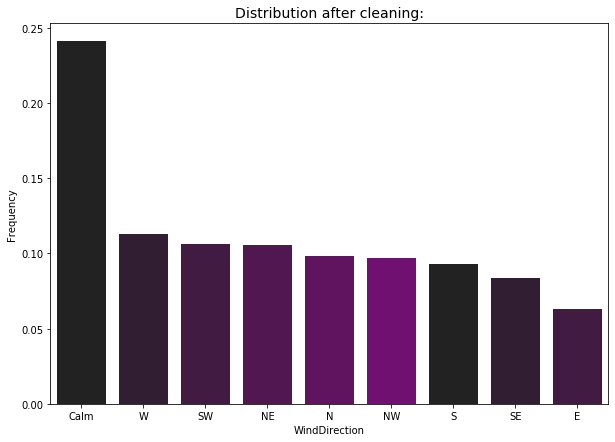

---------------------
New distribution:

WindDirection
Calm    0.241034
W       0.112813
SW      0.106124
NE      0.105477
N       0.098183
NW      0.096975
S       0.092702
SE      0.083682
E       0.063010
Name: WindDirection, dtype: float64
---------------------


In [9]:
bugged_windspeed = data.loc[(data['WindDirection']=='Calm')&(data['WindSpeed']!=0)].index
bugged_winddir = data.loc[(data['WindSpeed']==0)&(data['WindDirection']!='Calm')].index

data.loc[data.index.isin(bugged_windspeed), 'WindSpeed'] = 0 
data.loc[data.index.isin(bugged_winddir), 'WindDirection'] = 'Calm'

data['WindDirection'] = data['WindDirection'].fillna(value='Calm')

numbers = ['1', '8', '13']

north = ['North', 'N', 'NNW', 'N-NE', 'From NNE']

northeast = ['NE', 'Northeast', 'NorthEast', 'North East', 'NNE']

east = ['E', 'East', 'EAST', 'ENE', 'East North East']+numbers

southeast = ['SE', 'Southeast', 'SSE', 'From SSE', 'South Southeast', 'ESE', 'East Southeast',
              'From ESE']

south = ['South', 'S', 'From S', 's', 'South Southwest', 'W-SW']

southwest = ['SW', 'From SW', 'SouthWest', 'Southwest', 'SSW', 'From SSW', 'From WSW',
             'West-Southwest']

west = ['W', 'West', 'From W', 'from W', 'WSW']

northwest = ['NW', 'Northwest', 'WNW', 'W-NW', 'West Northwest', 'From NNW']

calm = ['Calm']

condlist = [
            data['WindDirection'].isin(north),
            data['WindDirection'].isin(northeast),
            data['WindDirection'].isin(east),
            data['WindDirection'].isin(southeast),
            data['WindDirection'].isin(south),
            data['WindDirection'].isin(southwest),
            data['WindDirection'].isin(west),
            data['WindDirection'].isin(northwest),
            data['WindDirection'].isin(calm),
            data['WindDirection'].isin(numbers)
           ]
choicelist = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'Calm', 'Number']

data['WindDirection'] = np.select(condlist, choicelist, default=None)

wind_direction = pd.Series(data.groupby('WindDirection')['WindDirection'].count()/len(data))
wind_direction.name = 'Frequency'
most_freq_dir = wind_direction.sort_values(ascending=False)

ax, fig = plt.subplots(figsize=(10,7))
sns.barplot(x=most_freq_dir.index, y=most_freq_dir, palette=sns.color_palette())
plt.title('Distribution after cleaning:', fontsize=14)

plt.show()

print('---------------------\nNew distribution:\n')
eds.group_by(data, 'WindDirection')
print('---------------------')

# Feature encoding and transformation

-Now when we are done with dealing with missing values, let's take a look at every feature and transform it if needed.

In [10]:
eds.look(data)

,Types,Counts,Distincts,Nulls,Missing ratio (%),Uniques,Skewness
GameId,int64,509762,512,0,0.0,"[[2017090700, 2017091000, 2017091001, 20170910...",0.054325
PlayId,int64,509762,23171,0,0.0,"[[20170907000118, 20170907000139, 201709070001...",0.054325
Team,object,509762,2,0,0.0,"[[away, home]]",NaN
X,float64,509762,10890,0,0.0,"[[73.91, 74.67, 74.0, 71.46, 69.32, 75.06, 74....",-0.018676
Y,float64,509762,4339,0,0.0,"[[34.84, 32.64, 33.2, 27.7, 35.42, 24.0, 16.64...",-0.010044
S,float64,509762,884,0,0.0,"[[1.69, 0.42, 1.22, 1.82, 1.01, 1.11, 1.24, 0....",0.474834
A,float64,509762,903,0,0.0,"[[1.13, 1.35, 0.59, 0.54, 2.43, 0.32, 0.83, 0....",0.942757
Dis,float64,509762,105,0,0.0,"[[0.4, 0.01, 0.31, 0.02, 0.16, 0.18, 0.13, 0.2...",0.257422
Orientation,float64,509762,36002,0,0.0,"[[81.99, 27.61, 3.01, 359.77, 12.63, 308.34, 3...",0.000846
Dir,float64,509762,36002,0,0.0,"[[177.18, 198.7, 202.73, 105.64, 164.31, 95.01...",-0.000100


In [11]:
#Irrelevant for NN training
others = ['GameId', 'PlayId', 'NflId', 'NflIdRusher', 'JerseyNumber']

away_mean = data.loc[data['Team']=='away']['Yards'].mean()
home_mean = data.loc[data['Team']=='home']['Yards'].mean()

if round(home_mean, 4)==round(away_mean, 4):
    others.append('Team')
    print('Home/away does not influence the yardage.\n(Team column removed)')

others_data = data[others]
data = data.drop(others, axis=1)

Home/away does not influence the yardage.
(Team column removed)


### X and Y

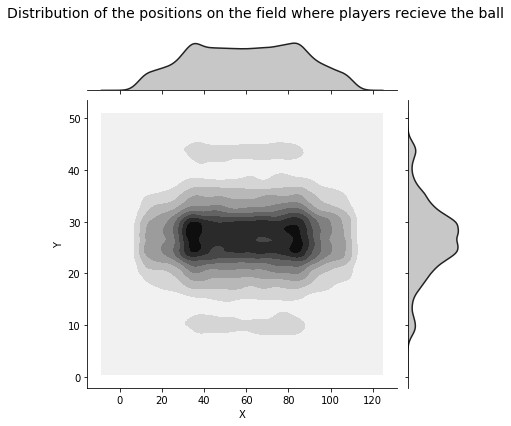

---------------------
X skewness:  -0.02
Y skewness:  -0.01 
---------------------


In [12]:
sns.jointplot(x='X', y='Y', data=data.sample(50000, random_state=13), kind='kde')

plt.subplots_adjust(top=0.9)
plt.suptitle('Distribution of the positions on the field where players recieve the ball',
             fontsize=14)
plt.show()

print('---------------------\nX skewness: ', round(data['X'].skew(), 2))
print('Y skewness: ', round(data['Y'].skew(), 2), '\n---------------------')

### S and A

S:


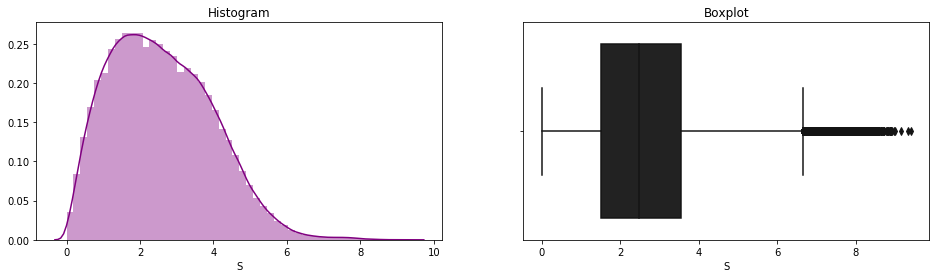

---------------------
Skewness: 0.4748340177363363 
---------------------
A:


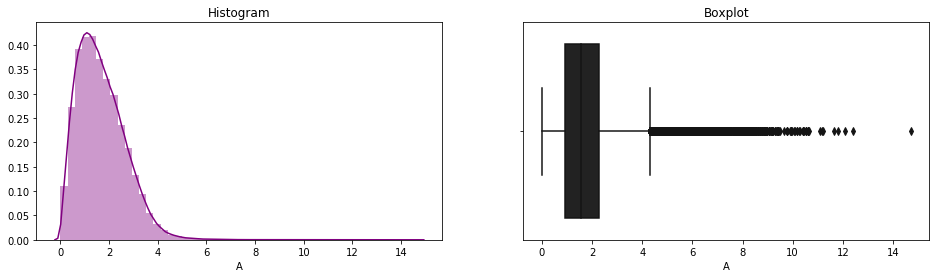

---------------------
Skewness: 0.9427571477245329 
---------------------


In [13]:
print('S:')
eds.plot_spread(data, 'S', color='purple')
print('---------------------\nSkewness:',data['S'].skew(), '\n---------------------')

print('A:')
eds.plot_spread(data, 'A', color='purple')
print('---------------------\nSkewness:',data['A'].skew(), '\n---------------------')

### Dis

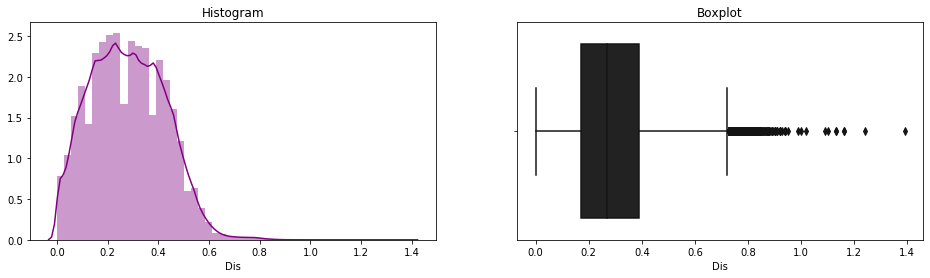

---------------------
Skewness: 0.2574221260249278 
---------------------


In [14]:
eds.plot_spread(data, 'Dis', color='purple')
print('---------------------\nSkewness:',data['Dis'].skew(), '\n---------------------')

### Orientation and Dir

Orientation:


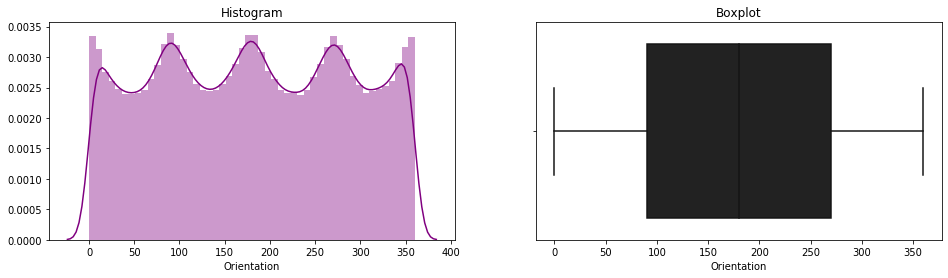

---------------------
Skewness: 0.0008463560834188558 
---------------------
Dir:


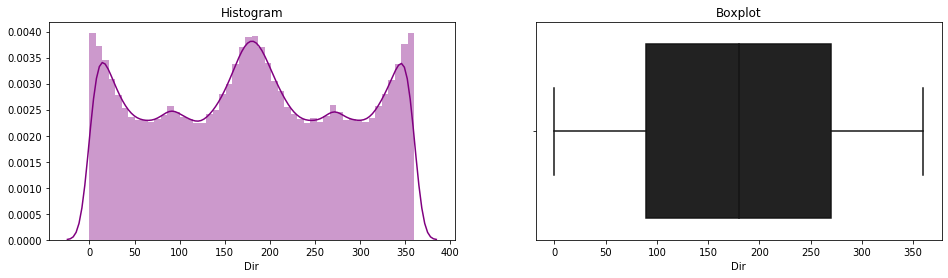

---------------------
Skewness: -0.00010005432752294468 
---------------------


In [15]:
print('Orientation:')
eds.plot_spread(data, 'Orientation', color='purple')
print('---------------------\nSkewness:',data['Orientation'].skew(), '\n---------------------')

print('Dir:')
eds.plot_spread(data, 'Dir', color='purple')
print('---------------------\nSkewness:',data['Dir'].skew(), '\n---------------------')

### DisplayName

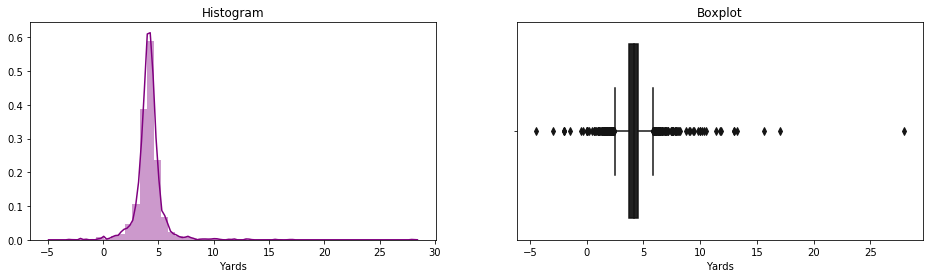

---------------------
Skewness: 3.871588456894808 
---------------------

It is to much disperse so we are going to move it out of the way.


In [16]:
name_data = pd.DataFrame(data.groupby('DisplayName')['Yards'].mean().sort_values(ascending=False))

eds.plot_spread(name_data, 'Yards', color='purple')
print('---------------------\nSkewness:',name_data['Yards'].skew(), '\n---------------------')
print('\nIt is to much disperse so we are going to move it out of the way.')

others_data = pd.concat([others_data, data['DisplayName']], axis=1)
data = data.drop('DisplayName', axis=1)

### Season (Season2018)

In [17]:
season_2018 = pd.get_dummies(data['Season']).iloc[:, 1]
data['Season2018'] = season_2018
data = data.drop('Season', axis=1)

print('---------------------\nSkewness:',data['Season2018'].skew(), '\n---------------------')

---------------------
Skewness: 0.05431217784867012 
---------------------


### YardLine

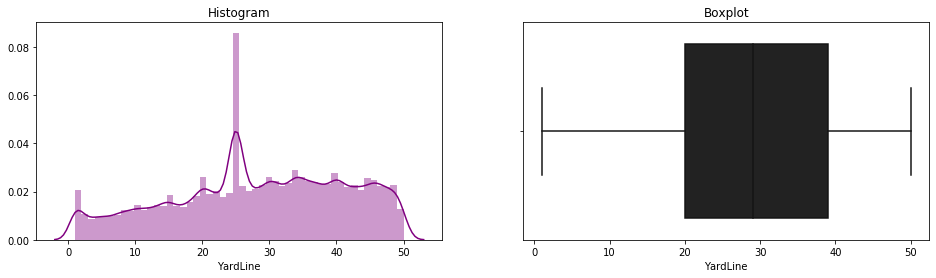

---------------------
Skewness: -0.2750296811341655 
---------------------


In [18]:
eds.plot_spread(data, 'YardLine', color='purple')
print('---------------------\nSkewness:',data['YardLine'].skew(), '\n---------------------')

### Quarter (IsOT)

In [19]:
print('---------------------\nYards per quarter:\n')
print(data.groupby('Quarter')['Yards'].mean().sort_values(ascending=False))
print('\nOnly OT seems to be significant\n---------------------\n')

is_ot = pd.get_dummies(data['Quarter']).iloc[:, 4]
data['IsOT'] = is_ot

others_data = pd.concat([others_data, data['Quarter']], axis=1)
data = data.drop('Quarter', axis=1)

print('\nQuarter dropped.')

---------------------
Yards per quarter:

Quarter
5    4.693642
3    4.377793
2    4.359748
1    4.137431
4    3.969723
Name: Yards, dtype: float64

Only OT seems to be significant
---------------------


Quarter dropped.


### GameClock (Minute)

In [20]:
data['Minute'] = data['GameClock'].str[:2]
data['Minute'] = data['Minute'].astype('int')
data = data.drop('GameClock', axis=1)

print('---------------------\nSkewness:',data['Minute'].skew(), '\n---------------------')

---------------------
Skewness: 0.04120151475212552 
---------------------


### PossessionTeam

In [21]:
#It is the same as Team column

others_data = pd.concat([others_data, data['PossessionTeam']], axis=1)
data = data.drop('PossessionTeam', axis=1)

print('PossessionTeam dropped.')

PossessionTeam dropped.


### Down

In [22]:
down = pd.get_dummies(data['Down'])
down.columns = ['Down1', 'Down2', 'Down3', 'Down4']

data = pd.concat([data, down.iloc[:, :3]], axis=1).drop('Down', axis=1)

print('Down encoded.')

Down encoded.


### Distance

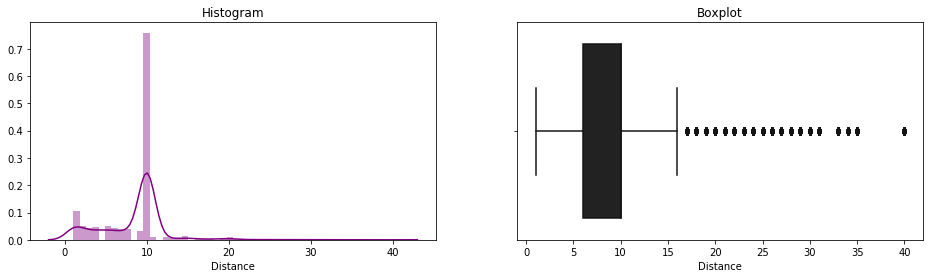

---------------------
Skewness: 0.16347464233095008 
---------------------


In [23]:
eds.plot_spread(data, 'Distance', color='purple')
print('---------------------\nSkewness:',data['Distance'].skew(), '\n---------------------')

### FieldPosition (FieldPositionAttack)

In [24]:
data['FieldPositionOwn'] = np.where(others_data['PossessionTeam']==data['FieldPosition'], 0, 1)

others_data = pd.concat([others_data, data['FieldPosition']], axis=1)
data = data.drop('FieldPosition', axis=1)

print('---------------------\nSkewness:',data['FieldPositionOwn'].skew(), '\n---------------------')

---------------------
Skewness: 0.27914697589590315 
---------------------


### HomeScoreBeforePlay and VisitorScoreBeforePlay (ScoreMargin)

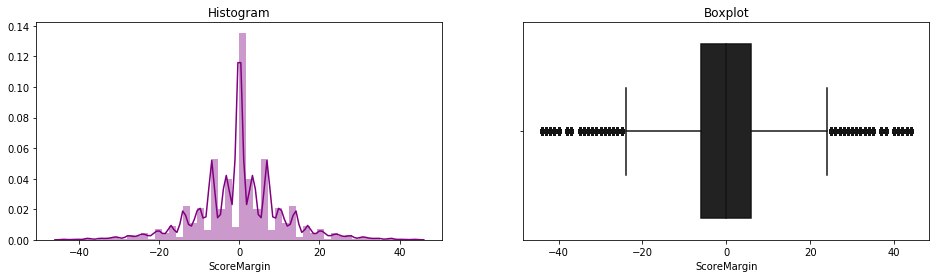

---------------------
Skewness: 0.0 
---------------------


In [25]:
data['ScoreMargin'] = np.where(others_data['Team']=='away', 
                               data['VisitorScoreBeforePlay']-data['HomeScoreBeforePlay'],
                               data['HomeScoreBeforePlay']-data['VisitorScoreBeforePlay'])

eds.plot_spread(data, 'ScoreMargin', color='purple')
print('---------------------\nSkewness:',data['ScoreMargin'].skew(), '\n---------------------')

### OffenseFormation

In [26]:
def does_bunch_of_stuff(df, column, target, prefix, cap=0.05):

    other = []

    for instance in df[column].unique():
        if df.loc[df[column]==instance][column].count()/len(df)<cap:
            other.append(instance)

    df[column] = np.where(df[column].isin(other), 'OTHER', df[column])

    data = df[[column, target]]

    data = data.groupby(column)[target].mean()
    data_percent = df.groupby(column)[column].count()/len(df)
    data = pd.concat([data, data_percent], axis=1)

    fig, ax = plt.subplots(figsize=(10,7))
    sns.barplot(x=data.index, y=data.iloc[:, 1], palette=sns.color_palette())
    ax2 = ax.twinx()
    sns.lineplot(x=data.index, y=data.iloc[:, 0], color='r')
    title = 'A look at the effect of '+column
    plt.title(title , fontsize=14)

    plt.show()

    print('---------------------\n', column, ' distribution:\n')
    eds.group_by(df, column)
    print('---------------------')

    encoded = pd.get_dummies(df[column]).add_prefix(prefix)

    df = pd.concat([df, encoded], axis=1)
    df = df.drop(column, axis=1)

    print('\n', column, ' encoded.')
    
    return df

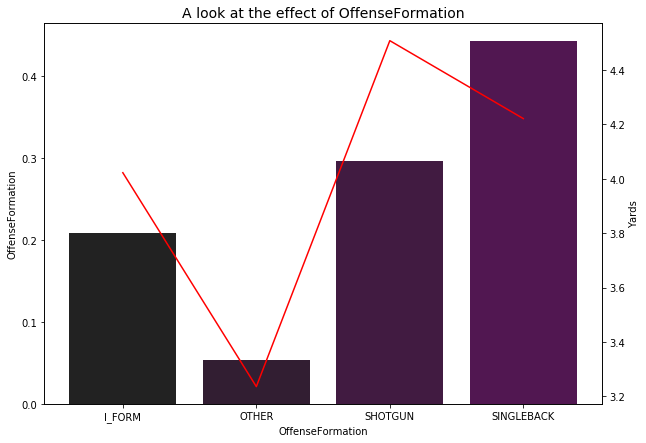

---------------------
 OffenseFormation  distribution:

OffenseFormation
SINGLEBACK    0.442450
SHOTGUN       0.296146
I_FORM        0.208062
OTHER         0.053343
Name: OffenseFormation, dtype: float64
---------------------

 OffenseFormation  encoded.


In [27]:
data = does_bunch_of_stuff(data, 'OffenseFormation', 'Yards', 'OffForm')

### OffensePersonnel 

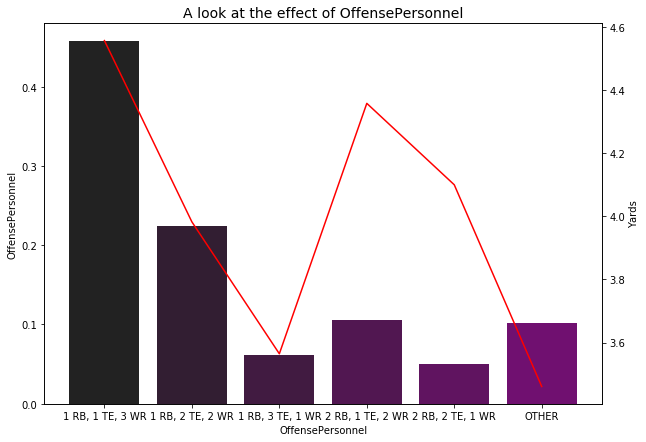

---------------------
 OffensePersonnel  distribution:

OffensePersonnel
1 RB, 1 TE, 3 WR    0.456994
1 RB, 2 TE, 2 WR    0.223814
2 RB, 1 TE, 2 WR    0.105218
OTHER               0.101895
1 RB, 3 TE, 1 WR    0.061413
2 RB, 2 TE, 1 WR    0.050667
Name: OffensePersonnel, dtype: float64
---------------------

 OffensePersonnel  encoded.


In [28]:
data = does_bunch_of_stuff(data, 'OffensePersonnel', 'Yards', 'OffPers')

### DefendersInTheBox

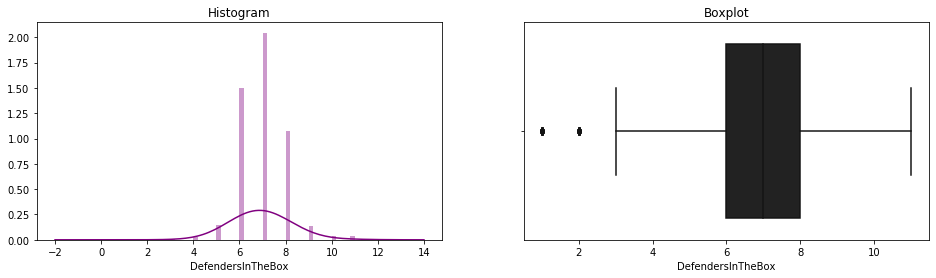

---------------------
Skewness: 0.5472016211818373 
---------------------


In [29]:
eds.plot_spread(data, 'DefendersInTheBox', color='purple')
print('---------------------\nSkewness:',data['DefendersInTheBox'].skew(), '\n---------------------')

### DefensePersonnel

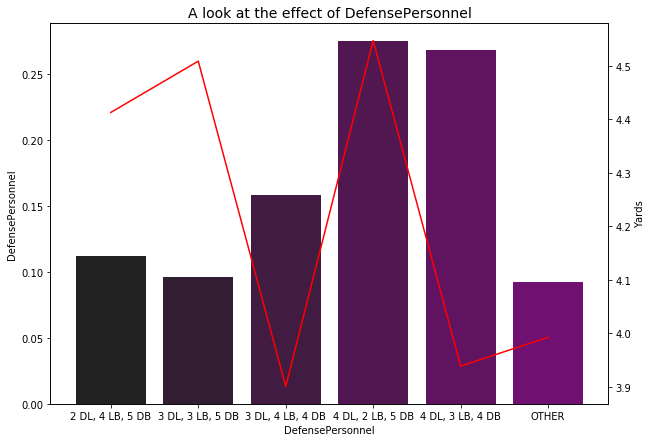

---------------------
 DefensePersonnel  distribution:

DefensePersonnel
4 DL, 2 LB, 5 DB    0.274395
4 DL, 3 LB, 4 DB    0.267792
3 DL, 4 LB, 4 DB    0.157783
2 DL, 4 LB, 5 DB    0.111691
3 DL, 3 LB, 5 DB    0.095896
OTHER               0.092443
Name: DefensePersonnel, dtype: float64
---------------------

 DefensePersonnel  encoded.


In [30]:
data = does_bunch_of_stuff(data, 'DefensePersonnel', 'Yards', 'DefPers')

###  PlayDirection

In [31]:
data['PlayDirectionRight'] = pd.get_dummies(data['PlayDirection']).iloc[:, 1]
data = data.drop('PlayDirection', axis=1)

print('PlayDirection encoded.')

PlayDirection encoded.


### TimeHandoff and TimeSnap (PlayBeginTimeSpan)

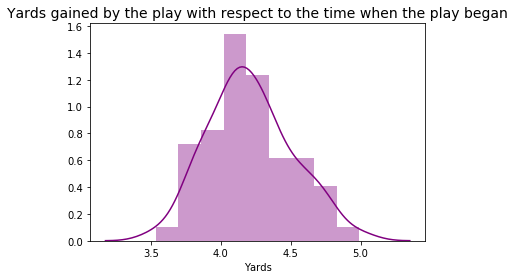

---------------------
Skewness: 0.30427927337872385 
---------------------
PlayBegin>=2 added.


In [32]:
sss = pd.concat([pd.DataFrame(data['TimeHandoff'].str.slice(-10, -8)), data['Yards']], axis=1)
sss = sss.groupby('TimeHandoff')['Yards'].mean().sort_values(ascending=False)

sns.distplot(sss, color='purple')
plt.title('Yards gained by the play with respect to the time when the play began',
          fontsize=14)
plt.show()

print('---------------------\nSkewness:',sss.skew(), '\n---------------------')

handoff_time = pd.to_datetime(data['TimeHandoff'].str.slice(-13, -1))
snap_time = pd.to_datetime(data['TimeSnap'].str.slice(-13, -1))

data['Arb'] = (handoff_time-snap_time).dt.seconds

data['PlayBegin>=2'] = np.where(data['Arb']>=2, 1, 0)

others_data = pd.concat([others_data, data['TimeHandoff'], data['TimeSnap']], axis=1)
data = data.drop(['TimeHandoff', 'TimeSnap', 'Arb'], axis=1)

print('PlayBegin>=2 added.')

### Yards

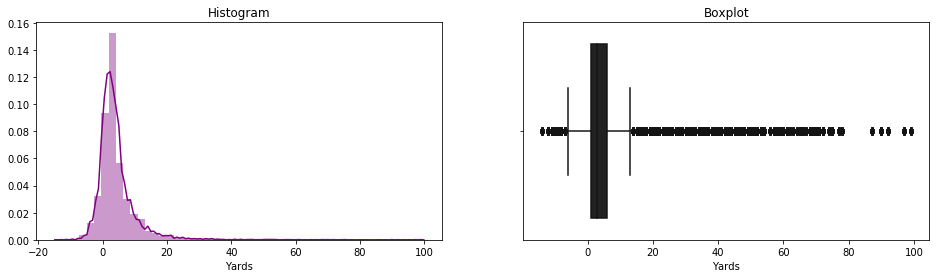

---------------------
Skewness: 4.18423409434044 
---------------------


In [33]:
eds.plot_spread(data, 'Yards', color='purple')
print('---------------------\nSkewness:',data['Yards'].skew(), '\n---------------------')

### PlayerHeight

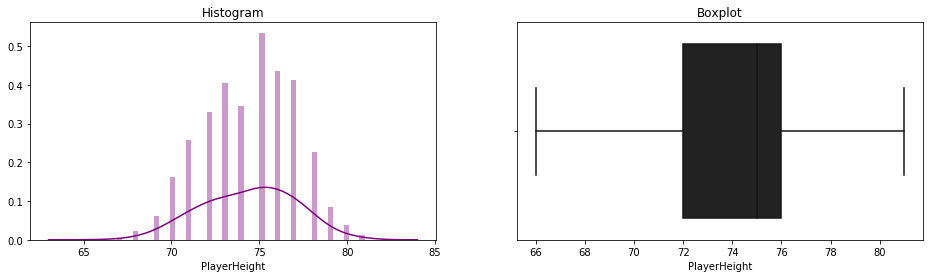

---------------------
Skewness: -0.16685979792815028 
---------------------


In [34]:
ft_to_in = pd.to_numeric(data['PlayerHeight'].str.slice(0,1))*12
data['PlayerHeight'] = ft_to_in+pd.to_numeric(data['PlayerHeight'].str.slice(2,4))

eds.plot_spread(data, 'PlayerHeight', color='purple')
print('---------------------\nSkewness:',data['PlayerHeight'].skew(), '\n---------------------')

### PlayerWeight

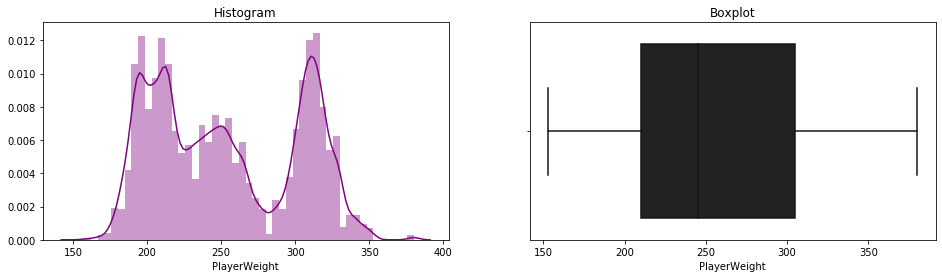

---------------------
Skewness: 0.23009361832093184 
---------------------


In [35]:
eds.plot_spread(data, 'PlayerWeight', color='purple')
print('---------------------\nSkewness:',data['PlayerWeight'].skew(), '\n---------------------')

### PlayerBirthDate (PlayerAgeDays)

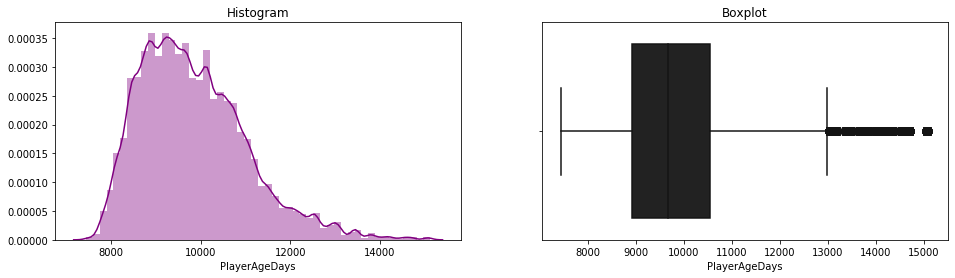

---------------------
Skewness: 0.8482690948969658 
---------------------


In [36]:
game_date = pd.to_datetime(others_data['TimeHandoff'].str.slice(0, 10))
data['PlayerAgeDays'] = game_date - pd.to_datetime(data['PlayerBirthDate'])
data['PlayerAgeDays'] = data['PlayerAgeDays'].dt.days

others_data = pd.concat([others_data, data['PlayerBirthDate']], axis=1)
data = data.drop('PlayerBirthDate', axis=1)

eds.plot_spread(data, 'PlayerAgeDays', color='purple')
print('---------------------\nSkewness:',data['PlayerAgeDays'].skew(), '\n---------------------')

### PlayerCollegeName

In [37]:
college_freqs = data.groupby('PlayerCollegeName')['PlayerCollegeName'].count()/len(data)
colleges = [freq for freq in college_freqs if freq>0.05]

if len(colleges)==0:
    others_data = pd.concat([others_data, data['PlayerCollegeName']], axis=1)
    data = data.drop('PlayerCollegeName', axis=1)
    print('All instances are to rare to be significant.')
else:
    data = does_bunch_of_stuff(data, 'PlayerCollegeName', 'Yards', 'College')

All instances are to rare to be significant.


### Position

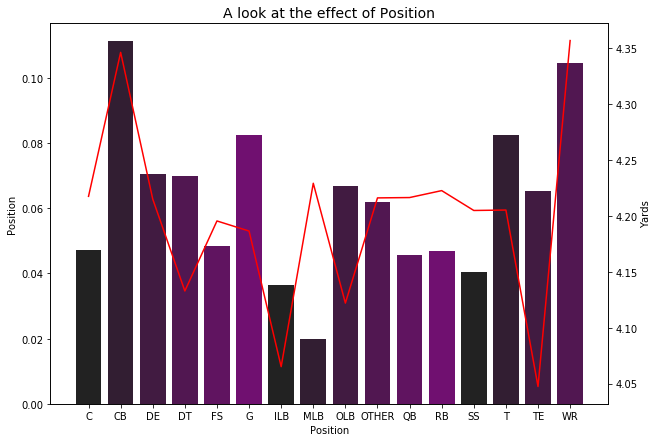

---------------------
 Position  distribution:

Position
CB       0.111201
WR       0.104608
G        0.082615
T        0.082482
DE       0.070405
DT       0.069909
OLB      0.066914
TE       0.065201
OTHER    0.061913
FS       0.048272
C        0.047202
RB       0.046900
QB       0.045688
SS       0.040293
ILB      0.036372
MLB      0.020025
Name: Position, dtype: float64
---------------------

 Position  encoded.


In [38]:
data = does_bunch_of_stuff(data, 'Position', 'Yards', 'PlayerPos', cap=0.02)

### HomeTeamAbbr and VisitorTeamAbbr

In [39]:
others_data = pd.concat([others_data, data[['HomeTeamAbbr', 'VisitorTeamAbbr']]], axis=1)
data = data.drop(['HomeTeamAbbr', 'VisitorTeamAbbr'], axis=1)

### Week, Stadium, Location, Turf

In [40]:
others_data = pd.concat([others_data, data[['Week', 'Stadium', 'Location', 'Turf']]], axis=1)
data = data.drop(['Week', 'Stadium', 'Location', 'Turf'], axis=1)

### StadiumType

In [41]:
data['StadiumTypeIndoors'] = np.where(data['StadiumType']=='Indoors', 1, 0)
data = data.drop('StadiumType', axis=1)

print('StadiumTypeIndoors encoded.')

StadiumTypeIndoors encoded.


### GameWeather

In [42]:
data = pd.concat([data, pd.get_dummies(data['GameWeather']).add_prefix('Weather')], axis=1)
data = data.drop('GameWeather', axis=1)

print('GameWeather encoded.')

GameWeather encoded.


### Temperature, Humidity and WindSpeed

Temperature:


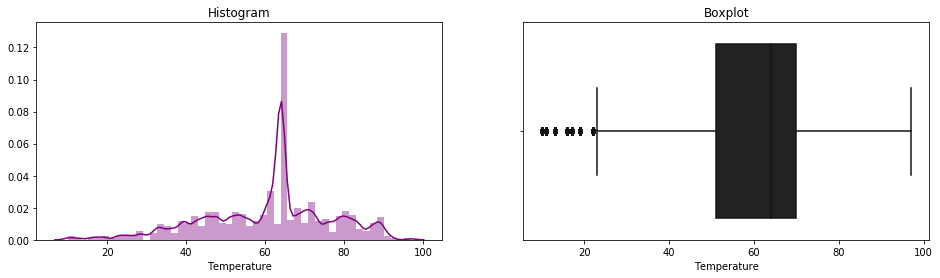

---------------------
Skewness: -0.4664175671785938 
---------------------
Humidity:


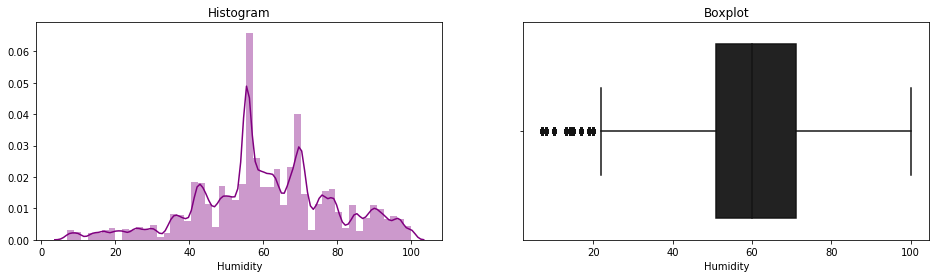

---------------------
Skewness: -0.22899508141749525 
---------------------
WindSpeed:


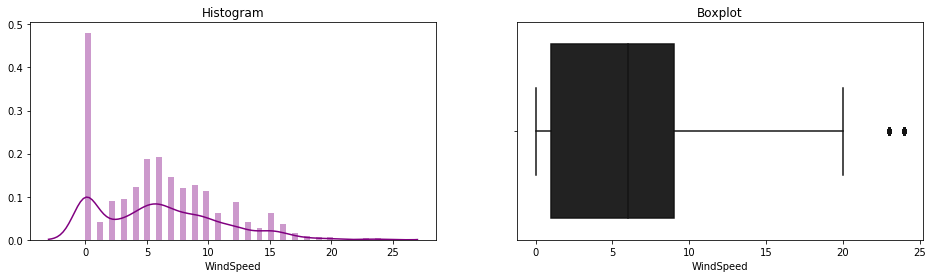

---------------------
Skewness: 0.6091939207709914 
---------------------


In [43]:
print('Temperature:')
eds.plot_spread(data, 'Temperature', color='purple')
print('---------------------\nSkewness:',data['Temperature'].skew(), '\n---------------------')

print('Humidity:')
eds.plot_spread(data, 'Humidity', color='purple')
print('---------------------\nSkewness:',data['Humidity'].skew(), '\n---------------------')

print('WindSpeed:')
eds.plot_spread(data, 'WindSpeed', color='purple')
print('---------------------\nSkewness:',data['WindSpeed'].skew(), '\n---------------------')

### WindDirection

In [44]:
data = pd.concat([data, pd.get_dummies(data['WindDirection']).add_prefix('WindDir')], axis=1)
data = data.drop('WindDirection', axis=1)

print('WindDirection encoded.')

WindDirection encoded.


### Removing excess features (n-1 degrees of freedom)

In [45]:
n1_cols = ['WindDirCalm', 'WeatherIndoors', 'PlayerPosOTHER', 'DefPersOTHER', 'OffPersOTHER',
           'OffFormOTHER']
data = data.drop(n1_cols, axis=1)

# Correlation between features and scaling

In [47]:
eds.look(data, pred='Yards').sort_values(by='Corr Yards', ascending=False)

,Types,Counts,Distincts,Nulls,Missing_ratio (%),Uniques,Skewness,Corr Yards
Yards,int64,509762,94,0,0.0,"[[8.0, 3.0, 5.0, 2.0, 7.0, 10.0, -1.0, 0.0, 9....",4.184234,1.00000
Distance,int64,509762,35,0,0.0,"[[2.0, 10.0, 7.0, 1.0, 9.0, 5.0, 6.0, 14.0, 8....",0.163475,0.07194
YardLine,int64,509762,50,0,0.0,"[[35.0, 43.0, 2.0, 25.0, 29.0, 19.0, 10.0, 50....",-0.275030,0.06455
"OffPers1 RB, 1 TE, 3 WR",uint8,509762,2,0,0.0,"[[1.0, 0.0]]",0.172666,0.04929
"DefPers4 DL, 2 LB, 5 DB",uint8,509762,2,0,0.0,"[[0.0, 1.0]]",1.011213,0.03202
Season2018,uint8,509762,2,0,0.0,"[[0.0, 1.0]]",0.054312,0.03135
OffFormSHOTGUN,uint8,509762,2,0,0.0,"[[1.0, 0.0]]",0.893010,0.02981
A,float64,509762,903,0,0.0,"[[1.13, 1.35, 0.59, 0.54, 2.43, 0.32, 0.83, 0....",0.942757,0.02259
Minute,int32,509762,16,0,0.0,"[[14.0, 13.0, 12.0, 11.0, 10.0, 9.0, 6.0, 3.0,...",0.041202,0.01680
Down1,uint8,509762,2,0,0.0,"[[0.0, 1.0]]",-0.299805,0.01645
